## PLN1 - Procesamiento del Lenguaje Natural I ##

Nombre: José Aviani

Código: a2103

### Desafío 3 ###

---

No vamos a hacer comentarios ni aclaraciones adicionales a todo lo que fue simplememnte tomado de la notebook presentada en clase.

---

### Dataset: ###

#### textos.info ####

##### 'La vuelta al mundo en 80 días' de Julio Verne ####

https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook

Utilizamos el mismo dataset que vimos en clase para tener una baseline con el que comparar.

---

Instalamos las librerías necesarias:

In [1]:
%pip install beautifulsoup4 --quiet
%pip install lxml --quiet
%pip install tensorflow --quiet

Hacemos los imports necesarios:

In [23]:
import random
import urllib.request
import bs4 as bs
from tensorflow.keras.utils import pad_sequences
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, TimeDistributed, SimpleRNN
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
random.seed(84)

---

Descargamos el dataset:

In [4]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [5]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' en el año 1872, la casa número 7 de saville-row, burlington gardens \r\n—donde murió sheridan en 1814— estaba habitada por phileas fogg, quien a\r\n pesar de que parecía haber tomado el partido de no hacer nada que \r\npudiese llamar la atención, era uno de los miembros más notables y \r\nsingulares del reformclub de londres. por consiguiente, phileas fogg, personaje enigmático y del cual sólo \r\nse sabía que era un hombre muy galante y de los más cumplidos gentlemen \r\nde la alta sociedad inglesa, sucedía a uno de los más grandes oradores \r\nque honran a inglaterra. decíase que se daba un aire a lo byron —su cabeza, se entiende, \r\nporque, en cuanto a los pies, no tenía defecto alguno—, pero a un byron \r\nde bigote y pastillas, a un byron impasible, que hubiera vivido mil años\r\n sin envejecer. phileas fogg, era inglés de pura cepa; pero quizás no había nacido en\r\n londres. jamás se le había visto en la bolsa ni en el banco, ni en \r\nninguno de los despachos mercantiles de 

---

Realizamos el pre-procesamiento para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

Estructuramos el problema de aprendizaje como *many-to-many*:
* Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]
* Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

In [6]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [7]:
# el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)
print(chars_vocab)

# la longitud de vocabulario de caracteres es:
vocab_size = len(chars_vocab)
print(vocab_size)

{'b', '«', '9', 'é', 'ñ', '(', 'g', '4', ',', 'ó', '\r', '\n', 'í', 'w', 'e', '.', 'k', 'á', 'v', 't', '<', ' ', 'l', '—', '1', '5', 'è', '~', '>', ';', 'ú', 'p', '"', '6', '/', 'x', '7', 'i', 'y', ':', 'z', '0', 'o', 'u', 'n', 'ü', 'h', 'm', 'q', '\t', 'j', 'a', "'", 'r', '¡', ')', 's', '!', '2', '8', '¿', '»', 'c', 'd', 'f', '3', '-', '?'}
68


In [8]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [9]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

print(tokenized_text[:1000])

[21, 14, 44, 21, 14, 22, 21, 51, 4, 42, 21, 24, 59, 36, 58, 8, 21, 22, 51, 21, 62, 51, 56, 51, 21, 44, 30, 47, 14, 53, 42, 21, 36, 21, 63, 14, 21, 56, 51, 18, 37, 22, 22, 14, 66, 53, 42, 13, 8, 21, 0, 43, 53, 22, 37, 44, 6, 19, 42, 44, 21, 6, 51, 53, 63, 14, 44, 56, 21, 10, 11, 23, 63, 42, 44, 63, 14, 21, 47, 43, 53, 37, 9, 21, 56, 46, 14, 53, 37, 63, 51, 44, 21, 14, 44, 21, 24, 59, 24, 7, 23, 21, 14, 56, 19, 51, 0, 51, 21, 46, 51, 0, 37, 19, 51, 63, 51, 21, 31, 42, 53, 21, 31, 46, 37, 22, 14, 51, 56, 21, 64, 42, 6, 6, 8, 21, 48, 43, 37, 14, 44, 21, 51, 10, 11, 21, 31, 14, 56, 51, 53, 21, 63, 14, 21, 48, 43, 14, 21, 31, 51, 53, 14, 62, 12, 51, 21, 46, 51, 0, 14, 53, 21, 19, 42, 47, 51, 63, 42, 21, 14, 22, 21, 31, 51, 53, 19, 37, 63, 42, 21, 63, 14, 21, 44, 42, 21, 46, 51, 62, 14, 53, 21, 44, 51, 63, 51, 21, 48, 43, 14, 21, 10, 11, 31, 43, 63, 37, 14, 56, 14, 21, 22, 22, 51, 47, 51, 53, 21, 22, 51, 21, 51, 19, 14, 44, 62, 37, 9, 44, 8, 21, 14, 53, 51, 21, 43, 44, 42, 21, 63, 14, 21, 22,

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.2
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]
tokenized_sentences_val = [val_text[i*max_context_size:(i+1)*max_context_size] for i in range(num_val)]

X_train = np.array(tokenized_sentences_train[:-1])
y_train = np.array(tokenized_sentences_train[1:])
X_val = np.array(tokenized_sentences_val[:-1])
y_val = np.array(tokenized_sentences_val[1:])


In [11]:
print(X_train.shape)
print(X_train[0,:10])
print(y_train[0,:10])

(319671, 100)
[21 14 44 21 14 22 21 51  4 42]
[14 44 21 14 22 21 51  4 42 21]


In [12]:
print(X_val.shape)
print(X_val[0,:10])
print(y_val[0,:10])

(799, 100)
[23 63 37 62 37 63 37 63 51 47]
[21 63 14 21  0 43 14 44 21 47]


---

Callback tomado de la notebook presentada en clase:

In [13]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_path, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.history_ppl = history_ppl

      self.model_path = model_path

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_path)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


---

In [14]:
models_folder = "models"
Path(models_folder).mkdir(parents=True, exist_ok=True)

Función para graficar un entrenamiento:

In [15]:
def graficar_entrenamiento(hist, history_ppl):
  # Perplejidad de entrenamiento a partir de la loss
  train_ppl = np.exp(hist.history['loss'])

  # Perplejidad de validación calculada por PplCallback
  val_ppl = np.array(history_ppl)

  # Ejes de epochs (1..n)
  epochs = np.arange(1, len(train_ppl) + 1)

  plt.figure(figsize=(8, 5))
  plt.plot(epochs, train_ppl, marker='o', label='Train perplexity')
  plt.plot(epochs, val_ppl, marker='o', label='Validation perplexity')

  plt.xlabel('Epoch')
  plt.ylabel('Perplexity')
  # escalar en log si los valores son muy grandes
  # plt.yscale('log')

  plt.title('Perplejidad por epoch (train vs val)')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

Funciones auxiliares para preparar contexto y el muestreo:

In [16]:
def prepare_seed(seed_text, char2idx, max_context_size):
    # Convertimos caracteres a índices, ignorando los que no estén en el vocabulario
    seed_idxs = [char2idx[c] for c in seed_text if c in char2idx]

    if len(seed_idxs) == 0:
        # Si la semilla no tiene ningún carácter válido, usamos un índice "neutro"
        seed_idxs = [0]

    # Truncamos si es más largo que max_context_size
    if len(seed_idxs) > max_context_size:
        seed_idxs = seed_idxs[-max_context_size:]

    # Padding por la izquierda si es más corto
    if len(seed_idxs) < max_context_size:
        padding = [0] * (max_context_size - len(seed_idxs))
        seed_idxs = padding + seed_idxs

    return np.array(seed_idxs, dtype=np.int32)


def sample_from_probs(probs, temperature=1.0):
    probs = np.asarray(probs).astype("float64")

    if temperature <= 0:
        temperature = 1e-8  # evitar divisiones por cero / log(0)

    # Ajuste por temperatura
    probs = np.power(probs, 1.0 / temperature)
    probs = probs / np.sum(probs)

    return np.random.choice(len(probs), p=probs)

Generación por Greedy Search:

In [17]:
def generate_text_greedy(model, seed_text, gen_length, char2idx, idx2char, max_context_size):
    context = prepare_seed(seed_text, char2idx, max_context_size)
    generated = list(seed_text)

    for _ in range(gen_length):
        x = context[np.newaxis, :]  # (1, max_context_size)

        # Salida del modelo: (1, seq_len, vocab_size)
        preds = model.predict(x, verbose=0)[0]  # (seq_len, vocab_size)
        probs_next = preds[-1]                  # tomamos la última posición

        # Greedy: índice con mayor probabilidad
        next_idx = np.argmax(probs_next)
        next_char = idx2char[next_idx]
        generated.append(next_char)

        # Actualizamos el contexto (desplazamos e insertamos el nuevo índice)
        context = np.roll(context, -1)
        context[-1] = next_idx

    return "".join(generated)

Generación por Beam Search determinístico:

In [18]:
def generate_text_beam_search(
    model,
    seed_text,
    gen_length,
    char2idx,
    idx2char,
    max_context_size,
    beam_width=3
):
    initial_context = prepare_seed(seed_text, char2idx, max_context_size)

    # Cada elemento del beam es: (lista_de_caracteres, contexto_indices, log_prob_acumulada)
    beam = [
        (list(seed_text), initial_context.copy(), 0.0)
    ]

    for _ in range(gen_length):
        new_beam = []

        for seq_chars, context, log_prob in beam:
            x = context[np.newaxis, :]
            preds = model.predict(x, verbose=0)[0]   # (seq_len, vocab_size)
            probs_next = preds[-1]                   # distribución del último paso

            # Top-k determinístico
            top_indices = np.argsort(probs_next)[::-1][:beam_width]

            for idx in top_indices:
                prob = probs_next[idx]
                if prob <= 0:
                    continue

                new_log_prob = log_prob + np.log(prob)
                next_char = idx2char[idx]
                new_seq_chars = seq_chars + [next_char]

                new_context = np.roll(context.copy(), -1)
                new_context[-1] = idx

                new_beam.append((new_seq_chars, new_context, new_log_prob))

        # Nos quedamos con las beam_width mejores secuencias
        new_beam.sort(key=lambda t: t[2], reverse=True)
        beam = new_beam[:beam_width]

    best_seq_chars, _, _ = beam[0]
    return "".join(best_seq_chars)


Generación por Beam Search estocástico con temperatura:

In [44]:
def generate_text_beam_search_stochastic(
    model,
    seed_text,
    gen_length,
    char2idx,
    idx2char,
    max_context_size,
    beam_width=3,
    temperature=1.0
):
    initial_context = prepare_seed(seed_text, char2idx, max_context_size)

    beam = [
        (list(seed_text), initial_context.copy(), 0.0)
    ]

    for _ in range(gen_length):
        new_beam = []

        for seq_chars, context, log_prob in beam:
            x = context[np.newaxis, :]
            preds = model.predict(x, verbose=0)[0]   # (seq_len, vocab_size)
            probs_next = preds[-1].astype("float64")

            # Ajuste por temperatura
            if temperature <= 0:
                temp = 1e-8
            else:
                temp = temperature

            probs_adj = np.power(probs_next, 1.0 / temp)
            probs_adj = probs_adj / np.sum(probs_adj)

            # Muestreamos beam_width índices (con reemplazo)
            sampled_indices = np.random.choice(
                len(probs_adj),
                size=beam_width,
                p=probs_adj
            )

            for idx in sampled_indices:
                prob = probs_adj[idx]
                if prob <= 0:
                    continue

                new_log_prob = log_prob + np.log(prob)
                next_char = idx2char[idx]
                new_seq_chars = seq_chars + [next_char]

                new_context = np.roll(context.copy(), -1)
                new_context[-1] = idx

                new_beam.append((new_seq_chars, new_context, new_log_prob))

        # Nos quedamos con las beam_width mejores según log_prob acumulada
        new_beam.sort(key=lambda t: t[2], reverse=True)
        beam = new_beam[:beam_width]

    best_seq_chars, _, _ = beam[0]
    return "".join(best_seq_chars)


Definimos los parámetros de las pruebas:

In [46]:
seed = "Era una noche oscura y " # Contexto inicial
gen_len = 300                    # Cantidad de caracteres a generar
beam_width = 5                   # Ancho del "haz" de los beam search (cuántas secuencias candidatas mantiene el algoritmo en cada paso)
temperatures = [0.7, 1.0, 1.3]   # Temperaturas

---

Proponemos dos arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

---

#### Arquitectura 1 – LSTM profunda con dos capas y regularización ####

Modelo de lenguaje a nivel carácter con una capa de embedding seguida de dos capas LSTM de 256 unidades con dropout y recurrent_dropout, que aprenden patrones de distinta complejidad y ayudan a capturar dependencias de corto y largo alcance. La salida es una capa Dense con activación softmax que modela la distribución de probabilidad del próximo carácter sobre todo el vocabulario.

In [20]:
entrenar_modelo1_flag = False # Definimos un flag para no reentrenar el modelo si no es necesario para evitar demoras

model1_path = f"{models_folder}/model1.keras"

Definimos el modelo:

In [21]:
# Definimos el modelo para la Arquitectura 1
def obtener_modelo1():
  model = Sequential()
  # Embedding de caracteres
  model.add(
      Embedding(
          input_dim=vocab_size,
          output_dim=128,
          input_length=max_context_size
      )
  )
  # Primera LSTM: devuelve secuencia completa
  model.add(
      LSTM(
          256,
          return_sequences=True,
          dropout=0.2,
          recurrent_dropout=0.2
      )
  )
  # Segunda LSTM: también devuelve secuencia completa
  model.add(
      LSTM(
          256,
          return_sequences=True,
          dropout=0.2,
          recurrent_dropout=0.2
      )
  )
  # Capa de salida aplicada en cada paso temporal
  model.add(
      TimeDistributed(
          Dense(vocab_size, activation='softmax')
      )
  )
  # Compilación
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer='rmsprop'
  )
  model.summary()

  return model


model1 = obtener_modelo1()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo:

In [ ]:
def entrenar_modelo1(model1, X_train, y_train, X_val, y_val, tokenized_sentences_val, model1_path):
  BATCH_SIZE = 64
  EPOCHS = 5 # Después de ciertas pruebas encontramos que el mejor modelo se alcanza antes de 5 epochs

  history_ppl = []
  hist = model1.fit(
      X_train,
      y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(X_val, y_val),
      callbacks=[PplCallback(tokenized_sentences_val, history_ppl, model1_path)]
  )

  return hist, history_ppl


if entrenar_modelo1_flag:
  modelo1_hist, modelo1_history_ppl = entrenar_modelo1(model1, X_train, y_train, X_val, y_val, tokenized_sentences_val, model1_path)


Epoch 1/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - loss: 2.2319
 mean perplexity: 4.662071397304535 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 3173s 633ms/step - loss: 2.2318 - val_loss: 6.4728
Epoch 2/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 1.4276
 mean perplexity: 4.345077135562897 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 3069s 614ms/step - loss: 1.4275 - val_loss: 7.2141
Epoch 3/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 1.2962
 mean perplexity: 4.296888938248157 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 2943s 589ms/step - loss: 1.2962 - val_loss: 7.6095
Epoch 4/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 1.2234
 mean perplexity: 4.301383152008056 

4995/4995 ━━━━━━━━━━━━━━━━━━━━ 2965s 594ms/step - loss: 1.2234 - val_loss: 7.8951
Epoch 5/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 1.1763
 mean perplexity: 4.381117283403873 

4995/4995 ━━━━━━━━━━━━━━━━━━━━ 2964s 593ms/step - loss: 1.1763 - val_loss: 8.1313

Graficamos el entrenamiento:

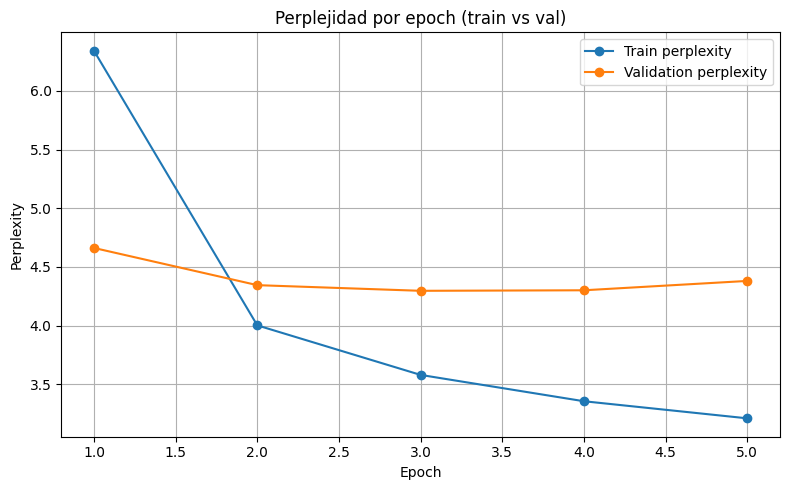

In [ ]:
if entrenar_modelo1_flag:
  graficar_entrenamiento(modelo1_hist, modelo1_history_ppl)

**Mejor perplexity ≈ 4.3**

El modelo está concentrando mucha probabilidad en caracteres correctos.



Levantamos el mejor modelo entrenado:

In [ ]:
model1 = keras.models.load_model(model1_path)

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 100, 68)        │        17,476 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,891,466 (7.22 MB)

 Trainable params: 945,732 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 945,734 (3.61 MB)

Generamos nuevas secuencias a partir de secuencias de contexto.

**Estrategia de greedy search:**

In [ ]:
def generar_secuencias_modelo1_greedy(seed, gen_len):
  texto_greedy = generate_text_greedy(
      model1,
      seed_text=seed,
      gen_length=gen_len,
      char2idx=char2idx,
      idx2char=idx2char,
      max_context_size=max_context_size
  )
  print("=== Greedy search ===")
  print(texto_greedy)


generar_secuencias_modelo1_greedy(seed, gen_len)

=== Greedy search ===
Era una noche oscura y 
algunos instantes de la mañana, el pasaporte se detuvo en el camino de la compañía de la 
compañía de la compañía de la compañía de la compañía de la compañía de la compañía de la 
compañía de la compañía de la compañía de la compañía de la compañía de la compañía de la 
compañía de la compañía


El resultado de greedy search muestra que el modelo captura bien el estilo y la sintaxis, pero termina cayendo en un bucle repetitivo, porque siempre elige el carácter más probable y no explora alternativas, lo que reduce mucho la diversidad del texto generado.

**Estrategia de beam search determinístico:**

In [ ]:
def generar_secuencias_modelo1_beam_det(seed, gen_len, beam_width):
  texto_beam = generate_text_beam_search(
      model1,
      seed_text=seed,
      gen_length=gen_len,
      char2idx=char2idx,
      idx2char=idx2char,
      max_context_size=max_context_size,
      beam_width=beam_width
  )
  print(f"\n=== Beam search determinístico (beam_width={beam_width}) ===")
  print(texto_beam)


generar_secuencias_modelo1_beam_det(seed, gen_len, beam_width)


=== Beam search determinístico (beam_width=5) ===
Era una noche oscura y se había estado en el 
compañero de los pasajeros del reform-club, cuando los pasajeros se habían entrado en el 
compañero de los pasajeros del reform-club, cuando los pasajeros se habían entrado en el 
compañero de los pasajeros del reform-club, cuando los pasajeros se habían entrado en su compa


El resultado de beam search determinístico muestra que el modelo mantiene un texto coherente con el estilo del corpus y construcciones sintácticas válidas, pero como prioriza siempre las secuencias globalmente más probables termina cayendo en un bucle casi idéntico, mostrando poca diversidad.

**Estrategia de beam search estocástico con distintas temperaturas:**

In [ ]:
def generar_secuencias_modelo1_beam_est(seed, gen_len, beam_width, temperatures):
  for temp in temperatures:
      texto_beam_stoch = generate_text_beam_search_stochastic(
          model1,
          seed_text=seed,
          gen_length=gen_len,
          char2idx=char2idx,
          idx2char=idx2char,
          max_context_size=max_context_size,
          beam_width=beam_width,
          temperature=temp
      )
      print(f"\n=== Beam search estocástico (beam_width={beam_width}, temperature={temp}) ===")
      print(texto_beam_stoch)


generar_secuencias_modelo1_beam_est(seed, gen_len, beam_width, temperatures)


=== Beam search estocástico (beam_width=5, temperature=0.7) ===
Era una noche oscura y se había 
estado a su compañero de la compañía de la compañía de la mañana, el 
camarote de la mañana, el pasaporte se detuvo en el camino de la compañía de la 
compañía de la compañía de la compañía de la compañía de la mañana, el 
camarote de la compañía de la mañana, el pasaporte se había rec

=== Beam search estocástico (beam_width=5, temperature=1.0) ===
Era una noche oscura y 
algunos instantes de la mañana, el país de la compañía de la mañana, el 
camarote de la mañana, el guía en el coronel para que el 
pasaporte se había recorrido en el camino de la mañana, el 
camarote de la mañana, el país de la compañía de la compañía de la 
compañía de la compañía de la mañan

=== Beam search estocástico (beam_width=5, temperature=1.3) ===
Era una noche oscura y 
la compañía de la mañana, el tren se había recorrido en el 
mar de la mañana, el guía de la mañana, el país de la 
compañía de la mañana, el g

El resultado de beam search estocástico con distintas temperaturas muestra que las tres temperaturas mantienen estilo y sintaxis razonables, pero se ve una preferencia por ciertos patrones.

Con T=0.7 el texto mantiene buena coherencia pero cae rápido en bucles largos.

Al subir a T=1.0 y 1.3 aumenta la diversidad, aunque también aparecen estructuras más caóticas y redundantes.

---


#### Arquitectura 2 – SimpleRNN ####

Modelo de lenguaje a nivel carácter que usa una capa Embedding seguida de una SimpleRNN de 128 unidades con dropout, que devuelve una secuencia de estados ocultos. Sobre cada paso temporal aplica una capa TimeDistributed(Dense + softmax) para obtener en cada posición del contexto una distribución de probabilidad sobre el próximo carácter del vocabulario, optimizado con rmsprop y pérdida sparse_categorical_crossentropy.

In [ ]:
entrenar_modelo2_flag = False # Definimos un flag para no reentrenar el modelo si no es necesario para evitar demoras

model2_path = f"{models_folder}/model2.keras"

Definimos el modelo:

In [34]:
# Definimos el modelo para la Arquitectura 2
def obtener_modelo2():
  model2 = Sequential()
  # Embedding de caracteres
  model2.add(
      Embedding(
          input_dim=vocab_size,
          output_dim=128,
          input_length=max_context_size
      )
  )
  # Capa SimpleRNN (Elman) que devuelve secuencia completa
  model2.add(
      SimpleRNN(
          128,
          return_sequences=True,
          dropout=0.2,
          recurrent_dropout=0.2
      )
  )
  # Capa de salida aplicada a cada paso temporal
  model2.add(
      TimeDistributed(
          Dense(vocab_size, activation='softmax')
      )
  )
  # Compilación: misma loss y optimizador recomendados
  model2.compile(
      loss='sparse_categorical_crossentropy',
      optimizer='rmsprop'
  )
  model2.summary()

  return model2


model2 = obtener_modelo2()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo:

In [37]:
def entrenar_modelo2(model2, X_train, y_train, X_val, y_val, tokenized_sentences_val, model2_path):
  BATCH_SIZE = 64
  EPOCHS = 20 # Después de ciertas pruebas encontramos que el mejor modelo se alcanza antes de 20 epochs

  history_ppl = []
  hist = model2.fit(
      X_train,
      y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(X_val, y_val),
      callbacks=[PplCallback(tokenized_sentences_val, history_ppl, model2_path)]
  )

  return hist, history_ppl


if entrenar_modelo2_flag:
  modelo2_hist, modelo2_history_ppl = entrenar_modelo2(model2, X_train, y_train, X_val, y_val, tokenized_sentences_val, model2_path)

Epoch 1/20
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6693
 mean perplexity: 5.122922140359878 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 93s 19ms/step - loss: 1.6693 - val_loss: 6.2729
Epoch 2/20
4994/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6642
 mean perplexity: 5.1113267499208455 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 93s 19ms/step - loss: 1.6642 - val_loss: 6.2632
Epoch 3/20
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6595
 mean perplexity: 5.08972135424614 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 93s 19ms/step - loss: 1.6595 - val_loss: 6.2852
Epoch 4/20
4992/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6565
 mean perplexity: 5.078236923217774 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 93s 19ms/step - loss: 1.6565 - val_loss: 6.3193
Epoch 5/20
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6538
 mean perplexity: 5.073869288861752 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 93s 19ms/step - loss: 1.6538

Graficamos el entrenamiento:

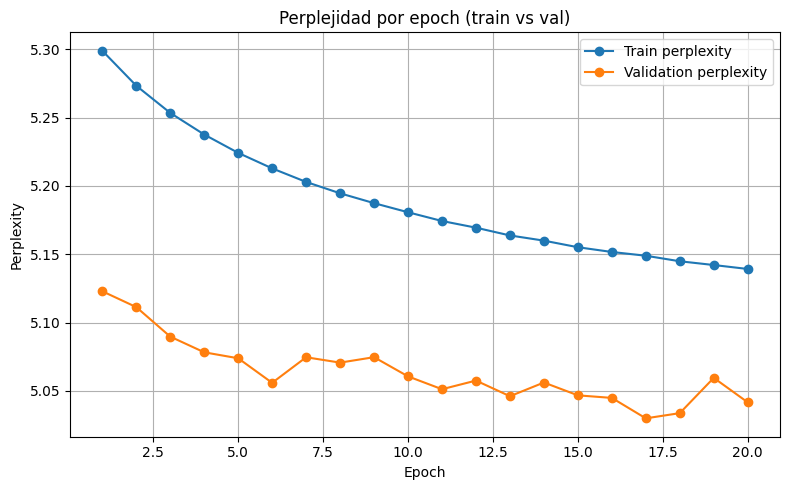

In [38]:
if entrenar_modelo2_flag:
  graficar_entrenamiento(modelo2_hist, modelo2_history_ppl)

**Mejor perplexity ≈ 5**

Este modelo también aprende una distribución bastante informativa, pero es claramente peor que el modelo 1, es decir, captura los patrones del texto con menor precisión y concentra menos probabilidad en los caracteres correctos.

Levantamos el mejor modelo entrenado:

In [47]:
model2 = keras.models.load_model(model2_path)

model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 100, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 100, 68)        │         8,772 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,746 (393.54 KB)

 Trainable params: 50,372 (196.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,374 (196.78 KB)

Generamos nuevas secuencias a partir de secuencias de contexto.

**Estrategia de greedy search:**

In [48]:
def generar_secuencias_modelo2_greedy(seed, gen_len):
  texto_greedy = generate_text_greedy(
      model2,
      seed_text=seed,
      gen_length=gen_len,
      char2idx=char2idx,
      idx2char=idx2char,
      max_context_size=max_context_size
  )
  print("=== Greedy search ===")
  print(texto_greedy)


generar_secuencias_modelo2_greedy(seed, gen_len)

=== Greedy search ===
Era una noche oscura y en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en el para en 


El resultado de greedy search muestra que el modelo se queda muy rápido atrapado en una repetición, sin llegar a desarrollar frases coherentes ni variación temática. Esto refleja que el modelo aprende patrones locales muy básicos pero no logra salir de eso.

**Estrategia de beam search determinístico:**

In [49]:
def generar_secuencias_modelo2_beam_det(seed, gen_len, beam_width):
  texto_beam = generate_text_beam_search(
      model2,
      seed_text=seed,
      gen_length=gen_len,
      char2idx=char2idx,
      idx2char=idx2char,
      max_context_size=max_context_size,
      beam_width=beam_width
  )
  print(f"\n=== Beam search determinístico (beam_width={beam_width}) ===")
  print(texto_beam)


generar_secuencias_modelo2_beam_det(seed, gen_len, beam_width)


=== Beam search determinístico (beam_width=5) ===
Era una noche oscura y de los compañeros de la compañeros de la compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañeros de los compañe


El resultado de beam search determinístico muestra que el modelo 2 también cae muy rápido en un bucle, repitiendo casi la misma frase sin avanzar en contenido. Esto muestra que, aun explorando varias ramas (beam_width=5), la SimpleRNN tiende a reforzar patrones muy frecuentes pero no consigue estructurar texto largo con coherencia global.

**Estrategia de beam search estocástico con distintas temperaturas:**

In [50]:
def generar_secuencias_modelo2_beam_est(seed, gen_len, beam_width, temperatures):
  for temp in temperatures:
      texto_beam_stoch = generate_text_beam_search_stochastic(
          model2,
          seed_text=seed,
          gen_length=gen_len,
          char2idx=char2idx,
          idx2char=idx2char,
          max_context_size=max_context_size,
          beam_width=beam_width,
          temperature=temp
      )
      print(f"\n=== Beam search estocástico (beam_width={beam_width}, temperature={temp}) ===")
      print(texto_beam_stoch)


generar_secuencias_modelo2_beam_est(seed, gen_len, beam_width, temperatures)


=== Beam search estocástico (beam_width=5, temperature=0.7) ===
Era una noche oscura y de la cara en el para en el para en el para en el 
con la cara de la cara en el para en el para de la cara en el para en el para en el para en el 
con la cara en el para en el para de la calcuta de la cara en el para de la cara en el 
con la cara en el para en el para en el para de la cara en el 

=== Beam search estocástico (beam_width=5, temperature=1.0) ===
Era una noche oscura y de la compañeros de la compañeros de la cara de la compañeros de la calcuta de la 
con la cara en el tren de la calcuta de la calcuta de la contrarse de la calcuta de la 
con la 
con la calcuta de la 
probable de la 
contrar en el 
con la contrarse de la calcuta de la 
probable de la cara de 

=== Beam search estocástico (beam_width=5, temperature=1.3) ===
Era una noche oscura y la carte, y de la 
con la 
contrario de los para de la cara de la 
contraba de la 
procurales de la 
compañeros de la 
probable de la 
probable 

El resultado de beam search estocástico con distintas temperaturas muestra que el modelo 2 gana algo de diversidad respecto a greedy/beam determinístico, pero incluso con T=0.7 sigue atrapado en repeticiones simples y no llega a construir frases largas coherentes.

Al subir a T=1.0 aparecen combinaciones un poco más variadas y menos previsibles, pero también con menos sentido y cortados, sin lógica clara.

Con T=1.3 la generación se vuelve aún más errática: mucha mezcla de palabras y repeticiones, lo que muestra que no logra una estructura global, el aumento de temperatura solo cambia el patrón de ruido.

---

#### Comparación arquitecturas 1 y 2 ####

En conjunto, el modelo 1 resulta claramente superior al modelo 2: alcanza una perplejidad de validación menor (~4.3 vs ~5) y las secuencias generadas, aunque tienden a patrones repetitivos, muestran mayor coherencia, continuidad y estilo más cercano al corpus.

El modelo 2 es más liviano y entrena mucho más rápido, pero cae enseguida en bucles muy simples y no logra sostener texto largo con buena estructura. La LSTM aprovecha mejor el contexto y ofrece un modelo de lenguaje mucho más útil; en cambio la SimpleRNN funciona como baseline más limitado.





---